In [2]:
import json
import chess
import zss
from tqdm import tqdm
import pickle
import random
from sklearn.cluster import OPTICS, cluster_optics_dbscan
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
from main import ChessTreeNode, expand_tree

In [2]:
# Read `all_trees`, parse to ChessTreeNode, and load to memory.
trees = {}
with open("all_trees", "r") as f:
    for idx, line in enumerate(tqdm(f.readlines())):
        puzzle_id, tree = json.loads(line)
        if len(tree) == 0:
            continue
        trees[puzzle_id] = ChessTreeNode(*tree[0])

    with open("tree_dict.pkl", "wb") as f:
        pickle.dump(trees, f)

KeyboardInterrupt: 

In [3]:
def compare(t1, t2):
    return zss.simple_distance(t1, t2, ChessTreeNode.get_children, ChessTreeNode.get_label, ChessTreeNode.compare)

def treeify_fen(fen):
    flipped = False
    board = chess.Board(fen)
    if board.turn == chess.BLACK:
        flipped = True
        board.apply_mirror()

    stockfish = chess.engine.SimpleEngine.popen_uci("./stockfish", timeout=None)
    try:
        return ChessTreeNode(*expand_tree(board.fen(), chess.Move.null(), stockfish)[0]), flipped
    finally:
        stockfish.quit()

In [4]:
with open("tree_dict_short.pkl", "rb") as f:
    trees = pickle.load(f)

In [26]:
custom_fens = {
    "smothered M2": "r3r2k/ppp2Qbp/2bp2p1/5PN1/4P3/1B2q2P/P5PK/8 w - - 0 25",
    "backrank M2": "6k1/1rp2pp1/5n1p/2B5/2RP4/4P3/P4PPP/6K1 b - - 0 24",
    "N forks QK": "2kr3r/2p5/ppq2n1p/3Np1p1/P3P3/1P6/Q2b1PPP/3RR1K1 w - - 0 22",
    "pinned pawn defender": "4r1k1/pb3p1p/1bp1q1p1/3pB3/3P4/1NP2PQP/PP4P1/R5K1 b - - 1 20",

}
custom_flipped = {}
for my_id, my_fen in custom_fens.items():
    t, flip = treeify_fen(my_fen)
    trees[my_id], custom_flipped[my_id] = t, flip
    print("="*50)
    print(my_id)
    print(my_fen)
    print(t.flip_san(flip))
    print("="*50)

smothered M2
r3r2k/ppp2Qbp/2bp2p1/5PN1/4P3/1B2q2P/P5PK/8 w - - 0 25
Qg8+ 4/1/2/1
  Rxg8 0/3/1/2
    Nf7# 2/0/0/1

backrank M2
6k1/1rp2pp1/5n1p/2B5/2RP4/4P3/P4PPP/6K1 b - - 0 24
Rb1+ 1/0/0/0
  Rc8 1/2/1/0
    Rxc8# 2/0/0/0

N forks QK
2kr3r/2p5/ppq2n1p/3Np1p1/P3P3/1P6/Q2b1PPP/3RR1K1 w - - 0 22
Ne7+ 2/0/0/0
  Kb7 0/4/0/1
    Nxc6 2/0/1/0
  Kd7 1/3/0/3
    Nxc6 2/0/1/0
  Kb8 0/1/0/1
    Nxc6+ 3/0/0/0
      Kc8 0/2/0/1
        Rxd2 1/2/1/1
      Kb7 1/3/0/0
        Nxd8+ 1/0/1/0
      Ka8 0/0/0/1
        Nxd8 0/0/1/0

pinned pawn defender
4r1k1/pb3p1p/1bp1q1p1/3pB3/3P4/1NP2PQP/PP4P1/R5K1 b - - 1 20
Qxe5 2/2/2/1
  Qxe4 2/1/1/1
    Rxe4 0/1/1/0
  Qf7 0/5/0/1
    Qe7 3/1/1/1
  Qh5 1/2/0/0
    Ba3 0/0/0/0
  f5 1/0/1/1
    Qe2 0/3/0/1



In [29]:
# Find a the top 5 best puzzles for these fens
for my_id, my_fen in custom_fens.items():
    print("="*50)
    print(my_id)
    print(my_fen)
    print("="*50)
    my_tree = trees[my_id]
    distances = []
    for pid, t in tqdm(list(trees.items())[:10000], leave=False):
        distances.append((compare(t, my_tree), pid, t))
    distances.sort()

    for dist, pid, t in distances[:5]:
        print(f"{pid} (DISTANCE {dist})")
        #print(t)
        print("-"*50)

smothered M2
r3r2k/ppp2Qbp/2bp2p1/5PN1/4P3/1B2q2P/P5PK/8 w - - 0 25


WFxEO (DISTANCE 130.0)
--------------------------------------------------
9DVVb (DISTANCE 135.0)
--------------------------------------------------
ZqnIv (DISTANCE 146.0)
--------------------------------------------------
NiGJB (DISTANCE 147.0)
--------------------------------------------------
1Kih5 (DISTANCE 149.0)
--------------------------------------------------
backrank M2
6k1/1rp2pp1/5n1p/2B5/2RP4/4P3/P4PPP/6K1 b - - 0 24


P21rY (DISTANCE 26.0)
--------------------------------------------------
aVf3C (DISTANCE 36.0)
--------------------------------------------------
7LdMa (DISTANCE 39.0)
--------------------------------------------------
hSGIk (DISTANCE 42.0)
--------------------------------------------------
SHwRf (DISTANCE 46.0)
--------------------------------------------------
N forks QK
2kr3r/2p5/ppq2n1p/3Np1p1/P3P3/1P6/Q2b1PPP/3RR1K1 w - - 0 22


qgoSj (DISTANCE 945.0)
--------------------------------------------------
remCi (DISTANCE 973.0)
--------------------------------------------------
duGFG (DISTANCE 979.0)
--------------------------------------------------
Ye071 (DISTANCE 992.0)
--------------------------------------------------
ml3vd (DISTANCE 994.0)
--------------------------------------------------
pinned pawn defender
4r1k1/pb3p1p/1bp1q1p1/3pB3/3P4/1NP2PQP/PP4P1/R5K1 b - - 1 20


Wvza0 (DISTANCE 1861.0)
--------------------------------------------------
Ljdzu (DISTANCE 1881.0)
--------------------------------------------------
HZGNS (DISTANCE 1885.0)
--------------------------------------------------
Tx0Dy (DISTANCE 1885.0)
--------------------------------------------------
SSeWb (DISTANCE 1891.0)
--------------------------------------------------


In [21]:
np.random.seed(0)
ids = np.random.choice([k for k, _ in trees.items() if k not in custom_fens], 400)
ids = np.concatenate((ids, list(custom_fens.keys())))

In [22]:
N = len(ids)
# Generate distance matrix. It's symmetric, so use that to halve running time.
d = np.zeros((N, N))
with tqdm(total=N*(N+1)//2) as pbar:
    for i in tqdm(range(N)):
        for j in range(i):
            d[i,j] = compare(trees[ids[i]], trees[ids[j]])
            pbar.update(1)
d = d + d.T


100%|█████████▉| 80200/80601 [06:13<00:01, 214.69it/s]


In [23]:
optics = OPTICS(metric="precomputed", min_cluster_size=5)
clust = optics.fit(d)

In [24]:
print("Cluster of puzzles from OPTICS")
for p, f in custom_fens.items():
    print(p, f)
    idx = np.where(ids==p)[0]
    this_cluster = np.nonzero(clust.labels_ == clust.labels_[idx])
    for close_id in this_cluster[0]:
        print(f"{ids[close_id]}, {d[idx, close_id][0]}")


Cluster of puzzles from OPTICS
smothered M2 r3r2k/ppp2Qbp/2bp2p1/5PN1/4P3/1B2q2P/P5PK/8 w - - 0 25
r6DZe, 2191.0
ZGPbW, 3128.0
RTCCg, 282.0
UKSiA, 2655.0
QIy7H, 485.0
Pfyaw, 2762.0
7SFV5, 3835.0
Z8r3C, 2267.0
T8d7f, 4593.0
jijlI, 4016.0
TIw3N, 201.0
AR0Bl, 1055.0
FUogu, 5016.0
VZ3sx, 4772.0
6hk5V, 3282.0
PCbZd, 523.0
pAU5P, 2597.0
Lmusl, 4403.0
iKw1Y, 531.0
yJ6be, 642.0
a7tye, 5880.0
dH3dP, 2806.0
VSkMX, 2682.0
0fNVf, 1358.0
18KZN, 2128.0
1vwoZ, 200.0
hDn2Q, 706.0
tFXLD, 4507.0
eGHAL, 559.0
NxkFQ, 4236.0
0EwnI, 1972.0
Uckrl, 5349.0
wOsV1, 2621.0
AD2N2, 3428.0
Ua1Eu, 1703.0
Ikplj, 1816.0
k1H9R, 4861.0
S9fRc, 1734.0
I2QZJ, 705.0
GSy2M, 2539.0
kWJet, 2178.0
G6zPN, 6057.0
CEfKE, 455.0
b5W88, 1563.0
QMC4b, 5101.0
HLfCB, 595.0
ApkQZ, 3218.0
LQc1u, 1901.0
8flTd, 3727.0
0nAHs, 2664.0
RadsI, 234.0
k6DyH, 1342.0
xnLfT, 2187.0
JP3pf, 2566.0
lgDQy, 3246.0
ba9Rv, 596.0
hG0NH, 652.0
kcyFE, 5224.0
ST0n6, 3514.0
5CaGQ, 174.0
TkpLZ, 5070.0
gWeoB, 3323.0
UXjB6, 1333.0
7Ma4d, 766.0
PFoV0, 4981.0
LTCQN, 4

[('smothered M2', array([-1]))]


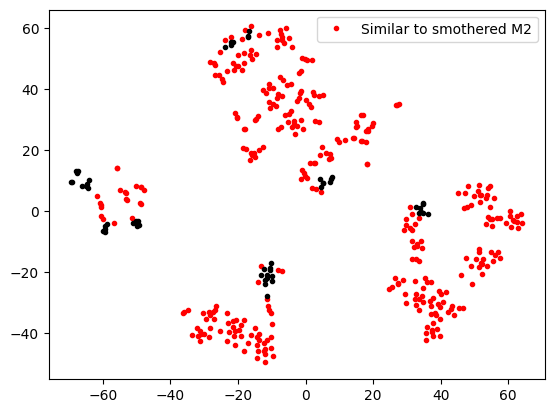

In [25]:
tsne = TSNE(metric="precomputed", init="random", random_state=0, perplexity=4)
y = tsne.fit_transform(d)

colours = ["r.", "g.", "b."]
labels = [(p, clust.labels_[np.where(ids==p)[0]]) for p, *_ in custom_fens.items()]
print(labels)

_, ax = plt.subplots()
# Plot our fens with special colours
for (p, c), col in zip(labels, colours):
    yc = y[clust.labels_ == c]
    ax.plot(yc[:, 0], yc[:, 1], col, label=f"Similar to {p}" )

# Plot the rest
for c in set(clust.labels_):
    if c in list(zip(*labels))[1]:
        continue
    yc = y[clust.labels_ == c]
    ax.plot(yc[:, 0], yc[:, 1], "k.")

ax.legend()
